# Heterogeneity model

Can we find correlates of the heterogeneity in peaking?

In [37]:
using GLM, DataFrames, Revise, Dates, StatsBase, CategoricalArrays, Plots, Distributions, RegressionTables, CSV, Pipe, ArchGDAL, Geodesy, LibSpatialIndex, ProgressMeter, ThreadsX,
    HypothesisTests
using KFactors

In [38]:
const METERS_PER_DEGREE_LAT = 111_000

111000

In [39]:
raw_data = read_data("../data/peaks_merged.parquet");

┌ Info: Removing sensors days with peak-hour occ above 99th percentile (22.83%)
└ @ KFactors C:\Users\mwbc\git\peak-spreading\src\computation.jl:65


In [40]:
data = KFactors.create_test_data(raw_data, KFactors.Periods.SPRING_2022);

## Create data

We create separate prepandemic and postlockdown data frames, then join.

In [41]:
prepandemic, postlockdown = map((:prepandemic, :postlockdown)) do period
    df = combine(groupby(data[data.period .== period, :], :station),
        :total_flow => mean => :mean_flow, # TODO or per lane?
        :urban => first => :urban,
        :District => first => :district,
        :Lanes => first => :lanes,
        :periods_imputed => mean => :periods_imputed,
        :peak_hour_start => (x -> mean(x .≤ Time(12, 00))) => :am_peak,
        :peak_hour_occ => mean => :peak_hour_occ
        # ideally we'd have something about network structure here but that's hard
    )
end;

In [42]:
estdata = leftjoin(prepandemic, postlockdown, on=:station, renamecols=:_prepandemic=>:_postlockdown)

,station,mean_flow_prepandemic,urban_prepandemic,district_prepandemic,lanes_prepandemic
,Int64?,Float64,Bool,Int64,Int64
1,312133,44047.5,1,3,3
2,312134,35867.3,1,3,2
3,312346,63659.2,1,3,3
4,312386,64762.7,1,3,3
5,312388,72300.3,1,3,3
6,312420,79235.5,1,3,3
7,312422,65046.1,1,3,3
8,312439,53270.3,1,3,4
9,312513,83750.8,1,3,3


In [43]:
meta = CSV.read("../data/sensor_meta_geo.csv", DataFrame)
leftjoin!(estdata, meta, on=:station=>:ID)

,station,mean_flow_prepandemic,urban_prepandemic,district_prepandemic,lanes_prepandemic
,Int64?,Float64,Bool,Int64,Int64
1,312133,44047.5,1,3,3
2,312134,35867.3,1,3,2
3,312346,63659.2,1,3,3
4,312386,64762.7,1,3,3
5,312388,72300.3,1,3,3
6,312420,79235.5,1,3,3
7,312422,65046.1,1,3,3
8,312439,53270.3,1,3,4
9,312513,83750.8,1,3,3


In [44]:
CSV.write("../data/stations_with_changes.csv", estdata)

"../data/stations_with_changes.csv"

In [45]:
estdata.Δpeak_hour_occ = estdata.peak_hour_occ_postlockdown .- estdata.peak_hour_occ_prepandemic
estdata.flow_change_ratio = estdata.mean_flow_postlockdown ./ estdata.mean_flow_prepandemic
estdata.Δmissing = (estdata.periods_imputed_postlockdown .- estdata.periods_imputed_prepandemic) ./ 288;

In [46]:
estdata.district = CategoricalVector(estdata.District)
estdata.flow_per_lane = estdata.mean_flow_prepandemic ./ estdata.Lanes
estdata.lane_group = recode(estdata.Lanes, missing, 1=>"1 or 2", 2=>"1 or 2", 3 => "3",
    4=>"4 or more", 5=>"4 or more", 6=>"4 or more", 7=>"4 or more", 8=>"4 or more")
@assert !any(ismissing.(estdata.lane_group))


In [47]:
estdata[ismissing.(estdata.lane_group),:]

,station,mean_flow_prepandemic,urban_prepandemic,district_prepandemic,lanes_prepandemic
,Int64?,Float64,Bool,Int64,Int64


In [48]:
estdata.prepandemic_mean_kflow = estdata.mean_flow_prepandemic ./ 1000 ./ 12;

## Heterogeneity plots

In [49]:
const UNC_BLUE = RGB(75/255, 156/255, 211/255)
const UNC_NAVY = RGB(19/255, 41/255, 75/255)
const UNC_DAVIE_GREEN = RGB(196/255, 214/255, 0/255)
const UNC_PINK = RGB(239/255, 68/255, 111/255)

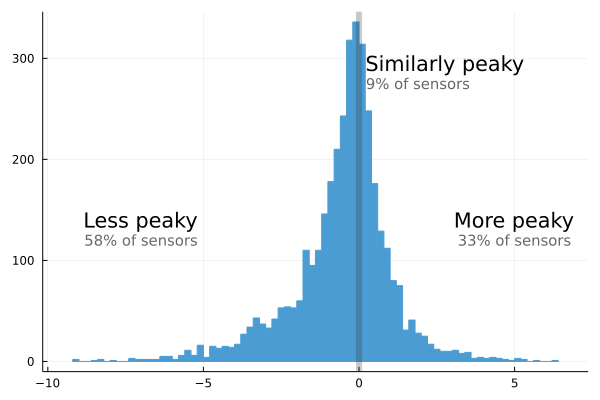

In [50]:
histogram(estdata.Δpeak_hour_occ * 100, legend=false, color=UNC_BLUE, line=UNC_BLUE)
vspan!([-0.1, 0.1], color=:gray20, opacity=0.25)
pct_less_peaky = mean(estdata.Δpeak_hour_occ .* 100 .< -0.1) * 100
pct_more_peaky = mean(estdata.Δpeak_hour_occ .* 100 .> 0.1) * 100
pct_similar = mean(abs.(estdata.Δpeak_hour_occ .* 100) .≤ 0.1) * 100
annotate!(-7, 140, text("Less peaky", pointsize=14))
annotate!(-7, 120, text("$(round(Int64, pct_less_peaky))% of sensors", pointsize=10, color=:gray40))

annotate!(5, 140, text("More peaky", pointsize=14))
annotate!(5, 120, text("$(round(Int64, pct_more_peaky))% of sensors", pointsize=10, color=:gray40))

annotate!(0.25, 295, text("Similarly peaky", pointsize=14, halign=:left))
annotate!(0.25, 275, text("$(round(Int64, pct_similar))% of sensors", pointsize=10, color=:gray40, halign=:left))
savefig("../fig/peakiness_change.pdf")
plot!()

## ANOVA between districts

In [27]:
anova = OneWayANOVATest(map(x -> estdata[estdata.District .== x, :Δpeak_hour_occ], unique(estdata.District))...)

LoadError: ArgumentError: unable to check bounds for indices of type Missing

## Geo data

Add some information about the spatial context of the sensors. First, compute average commute distance using LODES.

In [28]:
lodes = CSV.read("../data/lodes/ca_od_main_JT00_2019.csv", DataFrame, types=Dict(:w_geocode => String, :h_geocode => String));

In [29]:
blocks = @pipe ArchGDAL.read("../data/lodes/tl_2019_06_tabblock10.shp") |>
    ArchGDAL.getlayer(_, 0) |>
    DataFrame(_)

,,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10
,IGeometry,String,String,String,String,String
1,Geometry: wkbPolygon,06,061,022011,2013,060610220112013
2,Geometry: wkbPolygon,06,061,022011,2027,060610220112027
3,Geometry: wkbPolygon,06,061,022011,2017,060610220112017
4,Geometry: wkbPolygon,06,061,022011,2028,060610220112028
5,Geometry: wkbPolygon,06,061,022011,1004,060610220111004
6,Geometry: wkbPolygon,06,061,022011,1010,060610220111010
7,Geometry: wkbPolygon,06,061,022011,1088,060610220111088
8,Geometry: wkbPolygon,06,061,022011,1007,060610220111007
9,Geometry: wkbPolygon,06,061,022011,1003,060610220111003


In [30]:
# index the internal points
function index_pts(geoids, lats, lons)
    res = Dict{String, LatLon{Float64}}()
    
    for (geoid, lat, lon) in zip(geoids, lats, lons)
        res[geoid] = LatLon(parse(Float64, lat), parse(Float64, lon))
    end
    
    res
end

intpts = index_pts(blocks.GEOID10, blocks.INTPTLAT10, blocks.INTPTLON10);
    

In [31]:
lodes.distance_meters = map(zip(lodes.h_geocode, lodes.w_geocode)) do (h, w)
    euclidean_distance(intpts[h], intpts[w])
end;

In [32]:
# using median rather than mean to avoid effects of people who live in LA and work remotely in Sacramento
# or something.
block_median_commute = @pipe groupby(lodes, :h_geocode) |>
    combine(_, [:distance_meters, :S000] => ((dist, count) -> wmedian(dist, count) / 1000) => :median_commute_km);

In [33]:
# assign each sensor to a block
function build_index(geometries)
    index = LibSpatialIndex.RTree(2) # TODO don't hardwire dimensions
    for (i, geom) in enumerate(geometries)
        env = ArchGDAL.envelope(geom)
        LibSpatialIndex.insert!(index, i, [env.MinX, env.MinY], [env.MaxX, env.MaxY])
    end
    index
end

function find_geometry_column(df)
    geomcol = nothing
    schema = Tables.schema(df)
    for (col, typ) in zip(schema.names, schema.types)
        if typ <: ArchGDAL.IGeometry
            isnothing(geomcol) || error("found multiple geometry columns: $geomcol, $col")
            geomcol = col
        end
    end
    geomcol
end

function sjoin!(df1, df2, op=ArchGDAL.intersects)
    geom1 = find_geometry_column(df1)
    geom2 = find_geometry_column(df2)
    
    # very naive, assumes one match per df1 row
    idx2 = build_index(df2[!, geom2])
    
    # might be slow - possibly type unstable
    df2rows = Union{Int64, Missing}[]
    for geom in df1[!, geom1]::Vector{<:ArchGDAL.IGeometry}
        join = missing
        env = ArchGDAL.envelope(geom)
        candidates = LibSpatialIndex.intersects(idx2, [env.MinX, env.MinY], [env.MaxX, env.MaxY])
        for candidate in candidates
            if op(geom, df2[candidate, geom2])
                join = candidate
                break
            end
        end
        
        push!(df2rows, join)
    end
    
    sch2 = Tables.schema(df2)
    columns = Dict{Symbol, Vector{Any}}()
    for (name, typ) in zip(sch2.names, sch2.types)
        if !(typ <: ArchGDAL.IGeometry)
            columns[name] = Vector{Union{typ, Missing}}()
            sizehint!(columns[name], length(df2rows))
        end
    end
    
    for row in df2rows
        for col in keys(columns)
            if ismissing(row)
                push!(columns[col], missing)
            else
                push!(columns[col], df2[row, col])
            end
        end
    end
    
    for (name, col) in columns
        name ∈ names(df1) && error("Duplicate columns $col!")          
        df1[!, name] = col
    end
end

sjoin! (generic function with 2 methods)

In [34]:
estdata.geometry = ArchGDAL.createpoint.(estdata.Longitude, estdata.Latitude);

LoadError: MethodError: no method matching createpoint(::Missing, ::Missing)
[0mClosest candidates are:
[0m  createpoint([91m::Function[39m, ::Any...; kwargs...) at C:\Users\mwbc\.julia\packages\ArchGDAL\Po27z\src\context.jl:264

In [35]:
leftjoin!(blocks, block_median_commute, on=:GEOID10=>:h_geocode)

,,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10
,IGeometry,String,String,String,String,String
1,Geometry: wkbPolygon,06,061,022011,2013,060610220112013
2,Geometry: wkbPolygon,06,061,022011,2027,060610220112027
3,Geometry: wkbPolygon,06,061,022011,2017,060610220112017
4,Geometry: wkbPolygon,06,061,022011,2028,060610220112028
5,Geometry: wkbPolygon,06,061,022011,1004,060610220111004
6,Geometry: wkbPolygon,06,061,022011,1010,060610220111010
7,Geometry: wkbPolygon,06,061,022011,1088,060610220111088
8,Geometry: wkbPolygon,06,061,022011,1007,060610220111007
9,Geometry: wkbPolygon,06,061,022011,1003,060610220111003


Nearest neighbor interpolation for median commute, important as many sensors are in blocks with no housing (freeway interchanges etc).

LibSpatialIndex.RTree(Ptr{Nothing} @0x0000600003d4b900, LibSpatialIndex.C.RT_RTree, 0x00000002, LibSpatialIndex.C.RT_Star, LibSpatialIndex.C.RT_Memory, 0x00000064, 0x00000064, 0x00000064, 0x00000064, 0x000003e8, 0x000001f4, true, 0x00000020, 0.7, 0.4, 0.3)

In [30]:
const MAX_RADIUS_METERS = 40000

40000

In [ ]:
bpts = ArchGDAL.createpoint.(parse.(Float64, blocks.INTPTLON10), parse.(Float64, blocks.INTPTLAT10))
bidx = build_index(bpts)

In [39]:
# Note: LibSpatialIndex not thread safe

gdal_to_ll(geom) = LatLon(ArchGDAL.gety(geom, 0), ArchGDAL.getx(geom, 0))

function nnimpute(geometry, median_commute_km, sidx)
    map(zip(geometry, median_commute_km)) do (geom, commute_km)
        if !ismissing(commute_km)
            return commute_km
        else
            env = ArchGDAL.envelope(geom)
            coslat = cosd(ArchGDAL.gety(geom, 0))
            # expanding envelope search
            radius_meters = 1000
            while radius_meters < MAX_RADIUS_METERS
                radius_degrees_lat = radius_meters / METERS_PER_DEGREE_LAT
                radius_degrees_lon = radius_degrees_lat / coslat
                candidates = LibSpatialIndex.intersects(
                    sidx,
                    [env.MinX - radius_degrees_lon, env.MinY - radius_degrees_lat],
                    [env.MaxX + radius_degrees_lon, env.MaxY + radius_degrees_lat]
                )

                # Ignore candidates more than 0.9 * radius_meters away
                # This avoids a situation where there is a candidate in one of the corners that is selected, but there
                # is a closer candidate directly N or S.
                # Multiplying by 0.9 avoids error introduced by treating the earth as a sphere (in the coslat calculation)
                best_distance = radius_meters * 0.9
                best_val = NaN

                
                for candidate ∈ candidates
                    if !ismissing(median_commute_km[candidate]) && (dist = euclidean_distance(gdal_to_ll(geom), gdal_to_ll(geometry[candidate]))) < best_distance
                        best_distance = dist
                        best_val = median_commute_km[candidate]
                    end
                end
                
                if !isnan(best_val)
                    return best_val
                else
                    radius_meters += 1000
                end
            end
        end
    end
end
                        
blocks.median_commute_km_nn = nnimpute(bpts, blocks.median_commute_km, bidx)
            

710145-element Vector{Union{Nothing, Float64}}:
  47.445697295998514
   7.5143663505522404
   7.703136142561008
 107.71782596804113
  12.963419020709855
  12.963419020709855
 137.0792218211162
 145.38458316176641
  12.963419020709855
 305.576657636525
 305.576657636525
 305.576657636525
 305.576657636525
   ⋮
 154.98771712658825
 119.06241074780554
 212.48673653160344
 212.48673653160344
 104.1089193283323
 212.48673653160344
 172.61630685186307
 212.48673653160344
 212.48673653160344
 212.48673653160344
 212.48673653160344
 212.48673653160344

In [40]:
sjoin!(estdata, blocks)

In [43]:
estdata.median_commute_km_bin = map(estdata.median_commute_km_nn) do d
    ismissing(d) && return missing
    d < 5 && return "[0, 5)"
    d < 10 && return "[5, 10)"
    d < 15 && return "[10, 15)"
    d < 20 && return "[15, 20)"
    d < 30 && return "[20, 30)"
    return "[30, ∞)"
end |> CategoricalArray;
countmap(estdata.median_commute_km_bin)

Dict{CategoricalValue{String, UInt32}, Int64} with 6 entries:
  "[30, ∞)"  => 762
  "[15, 20)" => 706
  "[10, 15)" => 798
  "[0, 5)"   => 77
  "[20, 30)" => 868
  "[5, 10)"  => 303

In [44]:
mod = lm(@formula(Δpeak_hour_occ ~ flow_change_ratio + Δmissing + prepandemic_mean_kflow + lane_group +
            prepandemic_urban + prepandemic_am_peak + district + prepandemic_periods_imputed + median_commute_km_bin),
            estdata)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Δpeak_hour_occ ~ 1 + flow_change_ratio + Δmissing + prepandemic_mean_kflow + lane_group + prepandemic_urban + prepandemic_am_peak + district + prepandemic_periods_imputed + median_commute_km_bin

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────────
                                        Coef.   Std. Error      t  Pr(>|t|)     Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                      -0.0119524    0.00307403   -3.89    0.0001  -0.0179795    -0.00592537
flow_change_ratio                -0.00627996   0.00182966   -3.43    0.0006  -0.00986727   -0.00269265
Δmissing                         -0.00985155   0.00152063   -6.48    <1e-09  -0.012833     -0.006

In [39]:
show(names(estdata))

["station", "prepandemic_mean_flow", "prepandemic_urban", "prepandemic_district", "prepandemic_lanes", "prepandemic_periods_imputed", "prepandemic_am_peak", "prepandemic_peak_hour_occ", "postlockdown_mean_flow", "postlockdown_urban", "postlockdown_district", "postlockdown_lanes", "postlockdown_periods_imputed", "postlockdown_am_peak", "postlockdown_peak_hour_occ", "Δpeak_hour_occ", "flow_change_ratio", "Δmissing", "district", "flow_per_lane", "lanes", "lane_group", "fwy_stable", "dir_stable", "lanes_stable", "max_shift_meters", "Latitude", "Longitude", "Fwy", "Dir", "District", "Lanes", "County", "geom", "urban"]

In [49]:
means_by_county_and_highway = @pipe groupby(estdata, [:County, :Fwy]) |> combine(_, :Δpeak_hour_occ => mean, :Δpeak_hour_occ => std) |> sort(_, [:County, :Fwy])
CSV.write("../data/means_by_county_and_highway.csv", means_by_county_and_highway)

"../data/means_by_county_and_highway.csv"

In [29]:
-0.0125 * std(estdata.Δmissing)

-0.0033255039894288956

In [53]:
@pipe groupby(estdata, [:County]) |> combine(_, :Δpeak_hour_occ => mean, :Δpeak_hour_occ => std, :station => length) |> sort(_, [:Δpeak_hour_occ_mean]) |> show(_, allrows=true)

39×4 DataFrame
 Row │ County  Δpeak_hour_occ_mean  Δpeak_hour_occ_std  station_length 
     │ Int64?  Float64              Float64             Int64          
─────┼─────────────────────────────────────────────────────────────────
   1 │    101         -0.0236575          NaN                        1
   2 │     67         -0.0177911            0.0192537              100
   3 │     81         -0.0173818            0.0215073               48
   4 │     75         -0.0113585            0.0289562               25
   5 │     59         -0.0107543            0.0170294              588
   6 │     17         -0.0102432            0.0126975                5
   7 │     47         -0.00861957           0.0178551               39
   8 │     73         -0.00829083           0.0186529              329
   9 │    113         -0.0082196            0.0216149               10
  10 │     85         -0.00591587           0.0246241              216
  11 │     57         -0.0053489            0.00546557     

In [101]:
data.am_peak = data.peak_hour_start .< Time(12, 0);
data.District = CategoricalVector(data.District)
data.Lanes = CategoricalVector(data.Lanes);
data.postlockdown = data.period .== :postlockdown;

In [115]:
mod2 = lm(@formula(peak_hour_occ ~ (demeaned_flow + Lanes + District + urban + am_peak + periods_imputed) * postlockdown), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

peak_hour_occ ~ 1 + demeaned_flow + Lanes + District + urban + am_peak + periods_imputed + postlockdown + demeaned_flow & postlockdown + Lanes & postlockdown + District & postlockdown + urban & postlockdown + am_peak & postlockdown + periods_imputed & postlockdown

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       Coef.   Std. Error        t  Pr(>|t|)     Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                      0.102406     0.000244614   418.64    <1e-99   0.101927      0.102885
demeaned_flow                   -2.04381e-7   1.2122e-9    -168.60    <1e-99  -2.06757e-7   -2.02006e-7
Lanes: 2             

In [114]:
nobs(mod2)

1.877179e6

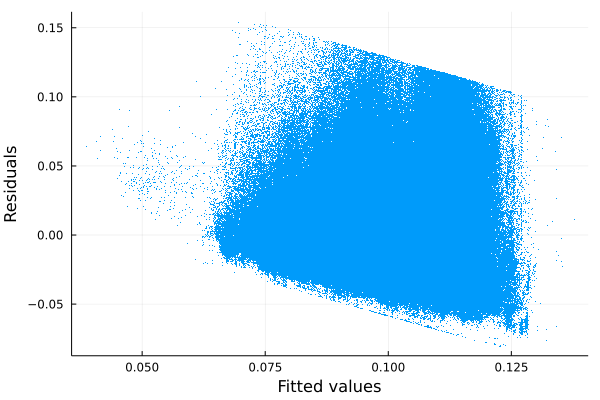

In [105]:
scatter(predict(mod2), residuals(mod2), markersize=0.0001, legend=false, format=:png)
xlabel!("Fitted values")
ylabel!("Residuals")

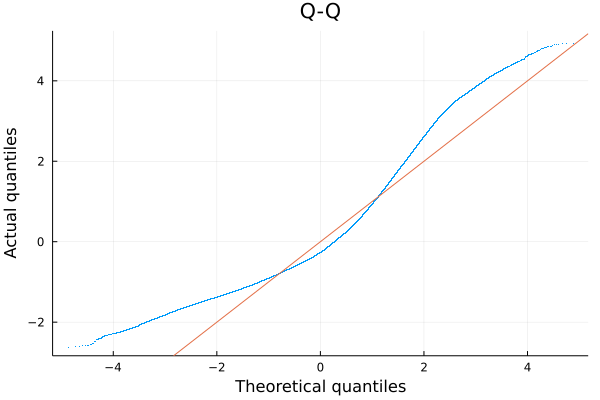

In [108]:
# normal q-q
sorted = sort(residuals(mod2))
sorted = sorted ./ std(sorted)
scatter(quantile.(Normal(), range(1/length(sorted), 1, length(sorted))), sorted, legend=false, markersize=0.01, format=:png)
Plots.abline!(1, 0)
title!("Q-Q")
xlabel!("Theoretical quantiles")
ylabel!("Actual quantiles")

In [91]:
regtable(mod, renderSettings=latexOutput())

\begin{tabular}{lr}
\toprule
                      & \multicolumn{1}{c}{Δpeak_hour_occ} \\ 
\cmidrule(lr){2-2} 
                      &                                (1) \\ 
\midrule
(Intercept)           &                          -0.008*** \\ 
                      &                            (0.002) \\ 
flow_change_ratio     &                             -0.000 \\ 
                      &                            (0.001) \\ 
Δmissing              &                          -0.000*** \\ 
                      &                            (0.000) \\ 
prepandemic_mean_flow &                           0.000*** \\ 
                      &                            (0.000) \\ 
lanes: 2              &                           -0.005** \\ 
                      &                            (0.002) \\ 
lanes: 3              &                          -0.010*** \\ 
                      &                            (0.002) \\ 
lanes: 4              &                          -0.012*** \